In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [20]:
feats_type = ['f0','mfcc', 'mfcc_d1','mfcc_d2','engy','envp','mel','sflux','sroll','loudness']
feats_column_name = ['engy_euc','engy_kl',
              'mfcc_euc','mfcc_kl',
              'mfcc_d1_euc','mfcc_d1_kl',
              'mfcc_d2_euc','mfcc_d2_kl',
              'envp_euc','envp_kl',
              'mel_euc','mel_kl',
              'sflux_euc','sflux_kl',
              'sroll_euc','sroll_kl',
              'loudness_euc','loudness_kl',
              'f0_euc','f0_kl',
              'xvec_euc','xvec_kl',
              'am_euc','am_kl'
                    ]
DF = pd.read_csv('./data/csvs/pooled_subject_response_acoustic_feats_data.csv')  


In [21]:
DF

,fIndex,fname,label,response,session,t_start,t_end,t_resp,subID,engy_euc,...,loudness_euc,loudness_kl,f0_euc,f0_kl,xvec_euc,xvec_kl,am_euc,am_kl,lang,changeIns
0,7,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TRAIN,0.0,7.302,7.978,1,0.377036,...,0.547695,0.217471,0.354577,0.405861,0.000000,0,0.354577,0,0,2.95
1,1,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TRAIN,0.0,6.282,6.787,1,0.002799,...,0.071446,0.104436,0.131971,0.940443,0.000000,0,0.131971,0,0,3.12
2,6,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TRAIN,0.0,5.754,6.209,1,0.270142,...,0.029739,0.000616,0.044131,0.508723,0.000000,0,0.044131,0,0,3.09
3,2,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,2,TRAIN,0.0,7.001,7.453,1,0.438505,...,0.133683,0.077877,0.147456,0.089739,0.000000,0,0.147456,0,0,3.45
4,8,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,2,TRAIN,0.0,7.391,8.875,1,0.279585,...,0.167329,0.042102,0.374662,0.544526,0.000000,0,0.374662,0,0,3.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,70,./playback/STIMULI/english/wavFilesTest/4044-9...,1,1,TEST,0.0,7.206,7.736,28,0.820564,...,0.410980,0.157783,0.043394,0.748491,35.007372,0,0.043394,0,1,3.17
6041,25,./playback/STIMULI/english/wavFilesTest/1594-1...,2,2,TEST,0.0,7.117,7.976,28,0.859333,...,0.301913,0.142402,0.013968,0.070470,44.726704,0,0.013968,0,1,3.56
6042,73,./playback/STIMULI/english/wavFilesTest/4137-1...,1,1,TEST,0.0,8.693,9.308,28,0.035433,...,0.100044,0.014940,0.045154,0.008022,33.810017,0,0.045154,0,1,3.69
6043,13,./playback/STIMULI/english/wavFilesTest/1246-1...,2,2,TEST,0.0,6.977,7.760,28,0.179433,...,0.293312,0.077572,0.255700,1.606971,47.511349,0,0.255700,0,1,3.60


In [22]:
DF['RT'] = DF['t_resp'] - DF['t_end'] # make a response time column
indx = []
indx.append(DF.loc[DF['session'] == 'TRAIN'].index.to_numpy()) # pick train samples
# indx.append(np.where(DF["label-response"].values !=0)[0]) # pick correct response
indx.append(np.where(DF["response"].values <0)[0]) # pick correct response
# indx.append(DF.loc[DF['lang'] == 0].index.to_numpy()) # chinese
# indx.append(DF.loc[DF['lang'] == 1].index.to_numpy()) # english
indx.append(np.where(DF["RT"].values <.200)[0]) # pick RT<200 msec
indx.append(np.where(DF["RT"].values >2)[0]) # pick RT>2000 msec

# for i in range(28):
#     indx.append(DF.loc[DF['subID']==(i+1)].index.to_numpy())

In [23]:
# pool indices to drop
indx_drop  = list(set(indx[0]) | set(indx[1]) | set(indx[2]) | set(indx[3]))

In [24]:
DF_pruned = DF.copy()
DF_pruned = DF_pruned.drop(index=indx_drop,axis=0)
DF_pruned['label-response'] = DF['label'] - DF['response'] # make a correct response column
DF_pruned

,fIndex,fname,label,response,session,t_start,t_end,t_resp,subID,engy_euc,...,f0_euc,f0_kl,xvec_euc,xvec_kl,am_euc,am_kl,lang,changeIns,RT,label-response
6,60,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TEST,0.0,6.524,7.100,1,0.213654,...,0.346402,0.847044,34.422130,0,0.346402,0,0,2.72,0.576,0
7,23,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TEST,0.0,7.561,8.018,1,0.224615,...,0.000750,0.012892,31.215648,0,0.000750,0,0,3.02,0.457,0
8,53,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,2,TEST,0.0,7.803,8.483,1,0.042936,...,0.030232,0.135561,57.658610,0,0.030232,0,0,3.08,0.680,0
9,15,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,1,TEST,0.0,7.217,7.644,1,0.127598,...,0.317897,0.525203,55.116579,0,0.317897,0,0,3.56,0.427,1
10,45,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,1,TEST,0.0,5.143,5.703,1,0.205375,...,0.012914,0.724925,46.407622,0,0.012914,0,0,2.53,0.560,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,70,./playback/STIMULI/english/wavFilesTest/4044-9...,1,1,TEST,0.0,7.206,7.736,28,0.820564,...,0.043394,0.748491,35.007372,0,0.043394,0,1,3.17,0.530,0
6041,25,./playback/STIMULI/english/wavFilesTest/1594-1...,2,2,TEST,0.0,7.117,7.976,28,0.859333,...,0.013968,0.070470,44.726704,0,0.013968,0,1,3.56,0.859,0
6042,73,./playback/STIMULI/english/wavFilesTest/4137-1...,1,1,TEST,0.0,8.693,9.308,28,0.035433,...,0.045154,0.008022,33.810017,0,0.045154,0,1,3.69,0.615,0
6043,13,./playback/STIMULI/english/wavFilesTest/1246-1...,2,2,TEST,0.0,6.977,7.760,28,0.179433,...,0.255700,1.606971,47.511349,0,0.255700,0,1,3.60,0.783,0


In [38]:
# md = smf.mixedlm("RT ~ mfcc+mfcc_d1+mfcc_d2+engy+envp+mel+sflux+sroll+loudness", DF, groups=DF["subID"])
# md = sm.OLS("RT ~ mfcc+mfcc_d1+mfcc_d2+engy+envp+mel+sflux+sroll+loudness", DF, groups=DF["subID"])
md = smf.ols("np.log10(RT) ~ mfcc_euc+mfcc_d1_euc+mfcc_d2_euc+engy_euc+envp_euc+mel_euc+f0_euc+sflux_euc\
             +sroll_euc+loudness_euc+xvec_euc+am_euc+C(subID)+C(lang)+\
             C(np.abs(label-response))+changeIns", data=DF_pruned)
# md = smf.ols("np.log10(RT) ~ mfcc_kl+mfcc_d1_kl+mfcc_d2_kl+engy_kl+envp_kl+mel_kl+f0_kl+sflux_kl\
#              +sroll_kl+loudness_kl+C(subID)+C(lang)+\
#              C(np.abs(label-response))+changeIns", data=DF_pruned)

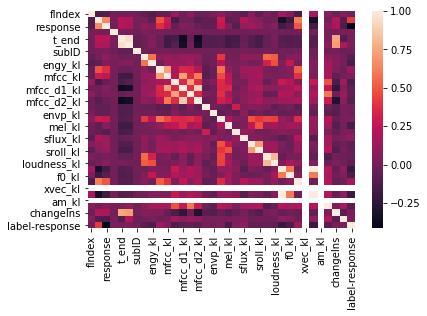

In [47]:
plt.scatter(DF_pruned['mfcc_d1_euc'],DF_pruned['mfcc_euc'])
corr = DF_pruned[].corr()
sns.heatmap(corr)
# plt.plot(DF_pruned['mfcc_euc'])
# plt.plot(DF_pruned['mfcc_d1_euc'])



In [40]:
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log10(RT)   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     42.72
Date:                Thu, 09 Apr 2020   Prob (F-statistic):          6.43e-289
Time:                        22:18:02   Log-Likelihood:                 1698.1
No. Observations:                4956   AIC:                            -3312.
Df Residuals:                    4914   BIC:                            -3039.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

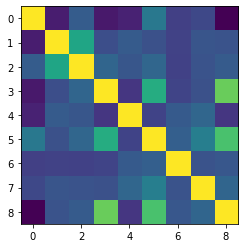

In [51]:
features = DF_pruned[feats_type].values
corr = np.corrcoef(features.T)
plt.imshow(corr,)

In [ ]:

prstd, iv_l, iv_u = wls_prediction_std(mdf)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

In [ ]:
# do a linear regression fit on chinese+correct: RT vs features

for i in range(28):
    indx_correct = []
    # collect all indices for chinese+correct
    indx_correct.append(np.array(list(set(indx[0]) & set(indx[1]) & set(indx[2]) & set(indx[4]) & set(indx[5])
                                     & set(indx[6+i]))))
    # collect all indices for english+correct
    indx_correct.append(np.array(list(set(indx[0]) & set(indx[1]) & set(indx[3]) & set(indx[4]) & set(indx[5])
                                      & set(indx[6+i]))))
    print("=====")
    for j in range(2):
        DF_subset = DF.loc[indx_correct[j], :]
        RT = DF_subset["RT"].values
        features = DF_subset[feats_type].values
        data_x = sm.add_constant(features,prepend=False)
        data_y = 10*np.log10(RT.copy()*1000)
#         data = sm.datasets.get_rdataset('dietox', 'geepack').data
        md = smf.mixedlm("RT ~ mfcc", DF, groups=DF["subID"])

#         mod = sm.OLS(data_y, data_x)
#         res = mod.fit()
#         mod = sm.MixedLM(data_y, data_x)
#         glm_gamma = sm.GLM(data_y, data_x, family=sm.families.Gamma())
#         res = glm_gamma.fit()    
#         print(res.summary())
        print(1/0)
    #     print(res.params)
#         print('r-square = '+str(res.rsquared))

In [ ]:
data_x = sm.add_constant(features,prepend=False)
data_y = 10*np.log10(RT.copy()*1000)
mod = sm.OLS(data_y, data_x)

In [ ]:
res = mod.fit()
# print(res.summary())
print(res.params)
print('r-square = '+str(res.rsquared))

In [ ]:
indx_correct[1]